In [1]:
import os
dataset_path = "/kaggle/input/journey-springfield-zip"  
print("Файлы в датасете:", os.listdir(dataset_path))

Файлы в датасете: ['sample_submission.csv', 'testset', 'characters_illustration.png', 'train']


In [2]:
import torch
import numpy as np

In [3]:
import pickle
import numpy as np
from skimage import io

from tqdm import tqdm, tqdm_notebook
from PIL import Image
from pathlib import Path

from torchvision import transforms
from multiprocessing.pool import ThreadPool
from sklearn.preprocessing import LabelEncoder
from torch.utils.data import Dataset, DataLoader
import torch.nn as nn

from matplotlib import colors, pyplot as plt
%matplotlib inline

import warnings
warnings.filterwarnings(action='ignore', category=DeprecationWarning)

In [4]:
# разные режимы датасета
DATA_MODES = ['train', 'val', 'test']
# все изображения будут масштабированы к размеру 224x224 px
RESCALE_SIZE = 224
# работаем на видеокарте
DEVICE = torch.device("cuda")

In [12]:
class SimpsonsDataset(Dataset):
    """
    Датасет с картинками, который паралельно подгружает их из папок
    производит скалирование и превращение в торчевые тензоры
    """
    def __init__(self, files, mode):
        super().__init__()
        # список файлов для загрузки
        self.files = sorted(files)
        # режим работы
        self.mode = mode

        if self.mode not in DATA_MODES:
            print(f"{self.mode} is not correct; correct modes: {DATA_MODES}")
            raise NameError

        self.len_ = len(self.files)

        self.label_encoder = LabelEncoder() #LabelEncoder для преобразования строковых меток классов в id и обратно

        if self.mode != 'test':
            self.labels = [path.parent.name for path in self.files]
            self.label_encoder.fit(self.labels)

            with open('label_encoder.pkl', 'wb') as le_dump_file:
                  pickle.dump(self.label_encoder, le_dump_file)

    def __len__(self):
        return self.len_

    def load_sample(self, file):
        image = Image.open(file)
        image.load()
        return image

    def __getitem__(self, index): #Возвращает (тензор изображения, метка) для обучения/валидации или только тензор для теста
        # для преобразования изображений в тензоры PyTorch и нормализации входа
        transform = transforms.Compose([
            transforms.ToTensor(), #конвертирует PIL Image с параметрами в диапазоне  [0,255]  (как все пиксели) в FloatTensor размера ( C×H×W )  [0,1]
            transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225]) #стандартная нормализация для предобученных моделей (среднее и std из ImageNet)            
        ])
        x = self.load_sample(self.files[index]) #Загружает изображение
        x = self._prepare_sample(x)             #Меняет размер до RESCALE_SIZE
        x = np.array(x / 255, dtype='float32')  #Нормализует значения пикселей в [0, 1] (деление на 255)
        x = transform(x)
        if self.mode == 'test':
            return x
        else:
            label = self.labels[index]
            label_id = self.label_encoder.transform([label])
            y = label_id.item()
            return x, y

    def _prepare_sample(self, image):
        image = image.resize((RESCALE_SIZE, RESCALE_SIZE))
        return np.array(image)

In [13]:
def imshow(inp, title=None, plt_ax=plt, default=False):
    """Imshow для тензоров"""
    inp = inp.numpy().transpose((1, 2, 0))
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    inp = std * inp + mean
    inp = np.clip(inp, 0, 1)
    plt_ax.imshow(inp)
    if title is not None:
        plt_ax.set_title(title)
    plt_ax.grid(False)

In [14]:
#определим директории с тренировочными и тестовыми файлами
TRAIN_DIR = Path('/kaggle/input/journey-springfield-zip/train')
TEST_DIR = Path('/kaggle/input/journey-springfield-zip/testset')

In [15]:
train_val_files = sorted(list(TRAIN_DIR.rglob('*.jpg')))
test_files = sorted(list(TEST_DIR.rglob('*.jpg')))

KeyboardInterrupt: 

In [7]:
from sklearn.model_selection import train_test_split

train_val_labels = [path.parent.name for path in train_val_files]
train_files, val_files = train_test_split(train_val_files, test_size=0.25,
                                          stratify=train_val_labels)

In [16]:
val_dataset = SimpsonsDataset(val_files, mode='val')

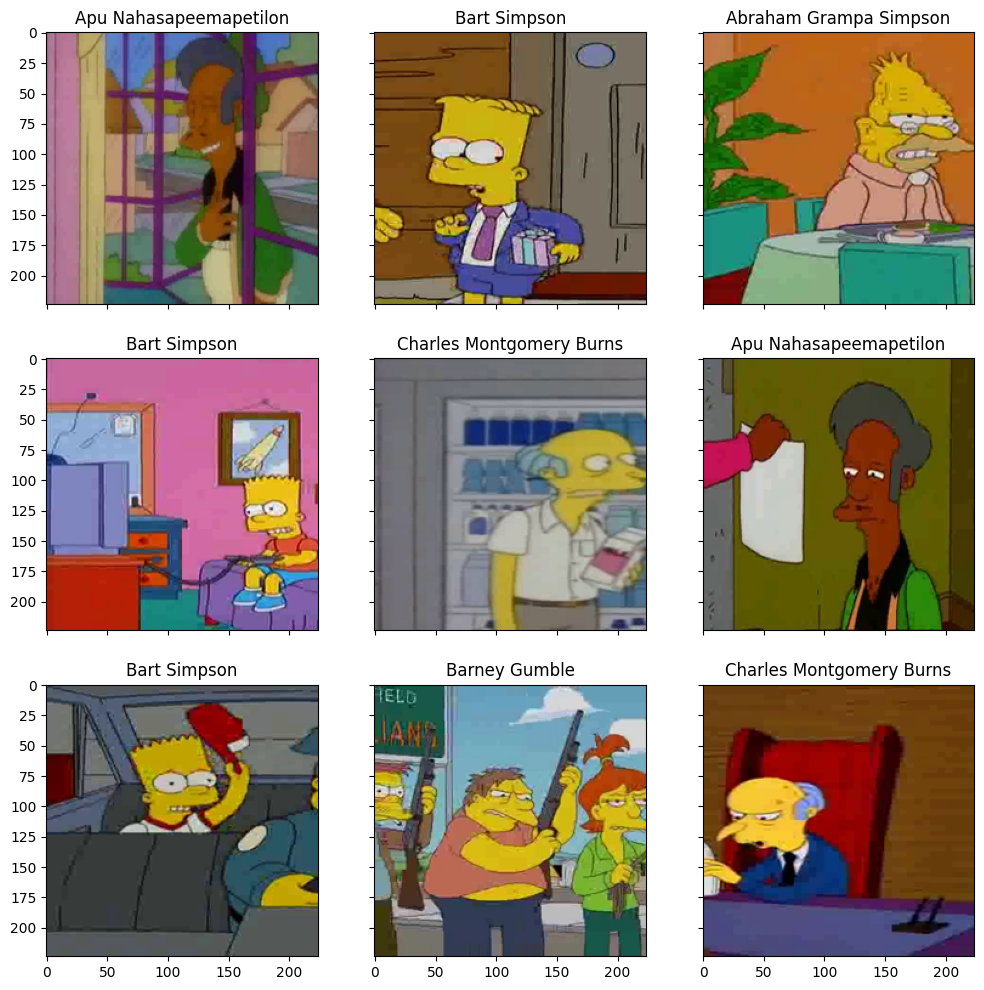

In [17]:
fig, ax = plt.subplots(nrows=3, ncols=3,figsize=(12, 12), \
                        sharey=True, sharex=True)
for fig_x in ax.flatten():
    random_characters = int(np.random.uniform(0,1000))
    im_val, label = val_dataset[random_characters]
    img_label = " ".join(map(lambda x: x.capitalize(),\
                val_dataset.label_encoder.inverse_transform([label])[0].split('_')))
    imshow(im_val.data.cpu(), \
          title=img_label,plt_ax=fig_x)

In [18]:
class SimpleCnn(nn.Module):
    def __init__(self, n_classes):
        super().__init__()
        self.conv1 = nn.Sequential(
            nn.Conv2d(in_channels=3, out_channels=8, kernel_size=3),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2)
        )
        self.conv2 = nn.Sequential(
            nn.Conv2d(in_channels=8, out_channels=16, kernel_size=3),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2)
        )
        self.conv3 = nn.Sequential(
            nn.Conv2d(in_channels=16, out_channels=32, kernel_size=3),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2)
        )
        self.conv4 = nn.Sequential(
            nn.Conv2d(in_channels=32, out_channels=64, kernel_size=3),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2)
        )
        self.conv5 = nn.Sequential(
            nn.Conv2d(in_channels=64, out_channels=96, kernel_size=3),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2)
        )

        self.out = nn.Linear(96 * 5 * 5, n_classes)


    def forward(self, x):
        x = self.conv1(x)
        x = self.conv2(x)
        x = self.conv3(x)
        x = self.conv4(x)
        x = self.conv5(x)

        x = x.view(x.size(0), -1)
        logits = self.out(x)
        return logits

In [19]:
def fit_epoch(model, train_loader, criterion, optimizer):
    
    running_loss = 0.0
    running_corrects = 0
    processed_data = 0

    for inputs, labels in train_loader:
        inputs = inputs.to(DEVICE)
        labels = labels.to(DEVICE)
        optimizer.zero_grad()

        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        preds = torch.argmax(outputs, 1)
        running_loss += loss.item() * inputs.size(0)
        running_corrects += torch.sum(preds == labels.data)
        processed_data += inputs.size(0)

    train_loss = running_loss / processed_data
    train_acc = running_corrects.cpu().numpy() / processed_data
    return train_loss, train_acc

In [20]:
def eval_epoch(model, val_loader, criterion):
   
    model.eval()
    running_loss = 0.0
    running_corrects = 0
    processed_size = 0

    for inputs, labels in val_loader:
        inputs = inputs.to(DEVICE)
        labels = labels.to(DEVICE)

        with torch.set_grad_enabled(False):
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            preds = torch.argmax(outputs, 1)

        running_loss += loss.item() * inputs.size(0)
        running_corrects += torch.sum(preds == labels.data)
        processed_size += inputs.size(0)
    val_loss = running_loss / processed_size
    val_acc = running_corrects.double() / processed_size
    return val_loss, val_acc

In [21]:
def train(train_files, val_files, model, epochs, batch_size):
    
    train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
    val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)

    history = []
    log_template = "\nEpoch {ep:03d} train_loss: {t_loss:0.4f} \
    val_loss {v_loss:0.4f} train_acc {t_acc:0.4f} val_acc {v_acc:0.4f}"

    with tqdm(desc="epoch", total=epochs) as pbar_outer:
        opt = torch.optim.Adam(model.parameters())
        criterion = nn.CrossEntropyLoss()

        for epoch in range(epochs):
            train_loss, train_acc = fit_epoch(model, train_loader, criterion, opt)
            print("loss", train_loss)

            val_loss, val_acc = eval_epoch(model, val_loader, criterion)
            history.append((train_loss, train_acc, val_loss, val_acc))

            pbar_outer.update(1)
            tqdm.write(log_template.format(ep=epoch+1, t_loss=train_loss,\
                                           v_loss=val_loss, t_acc=train_acc, v_acc=val_acc))

    return history

In [22]:
def predict(model, test_loader):

    with torch.no_grad():
        logits = []

        for inputs in test_loader:
            inputs = inputs.to(DEVICE)
            model.eval()
            outputs = model(inputs).cpu()
            logits.append(outputs)

    probs = nn.functional.softmax(torch.cat(logits), dim=-1).numpy()
    return probs

In [23]:
n_classes = len(np.unique(train_val_labels))
simple_cnn = SimpleCnn(n_classes).to(DEVICE)
print("we will classify :{}".format(n_classes))
print(simple_cnn)

we will classify :42
SimpleCnn(
  (conv1): Sequential(
    (0): Conv2d(3, 8, kernel_size=(3, 3), stride=(1, 1))
    (1): ReLU()
    (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (conv2): Sequential(
    (0): Conv2d(8, 16, kernel_size=(3, 3), stride=(1, 1))
    (1): ReLU()
    (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (conv3): Sequential(
    (0): Conv2d(16, 32, kernel_size=(3, 3), stride=(1, 1))
    (1): ReLU()
    (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (conv4): Sequential(
    (0): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1))
    (1): ReLU()
    (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (conv5): Sequential(
    (0): Conv2d(64, 96, kernel_size=(3, 3), stride=(1, 1))
    (1): ReLU()
    (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (out): Linear(in_features=2400, out_fea

In [24]:
if val_dataset is None:
    val_dataset = SimpsonsDataset(val_files, mode='val')

train_dataset = SimpsonsDataset(train_files, mode='train')

history = train(train_dataset, val_dataset, model=simple_cnn, epochs=2, batch_size=64)

epoch:   0%|          | 0/2 [00:09<?, ?it/s]


KeyboardInterrupt: 

In [ ]:
loss, acc, val_loss, val_acc = zip(*history)

plt.figure(figsize=(15, 9))
plt.plot(loss, label="train_loss")
plt.plot(val_loss, label="val_loss")
plt.legend(loc='best')
plt.xlabel("epochs")
plt.ylabel("loss")
plt.show()

In [ ]:
def predict_one_sample(model, inputs, device=DEVICE):
    """Предсказание, для одной картинки"""
    with torch.no_grad():
        inputs = inputs.to(device)
        model.eval()
        logit = model(inputs).cpu()
        probs = torch.nn.functional.softmax(logit, dim=-1).numpy()
    return probs

In [9]:
random_characters = int(np.random.uniform(0,1000))
ex_img, true_label = val_dataset[random_characters]
probs_im = predict_one_sample(simple_cnn, ex_img.unsqueeze(0))

NameError: name 'val_dataset' is not defined

In [ ]:
idxs = list(map(int, np.random.uniform(0,1000, 20)))
imgs = [val_dataset[id][0].unsqueeze(0) for id in idxs]

probs_ims = predict(simple_cnn, imgs)

In [10]:
label_encoder = pickle.load(open("label_encoder.pkl", 'rb'))

y_pred = np.argmax(probs_ims,-1)

actual_labels = [val_dataset[id][1] for id in idxs]

preds_class = [label_encoder.classes_[i] for i in y_pred]

from sklearn.metrics import f1_score
f1 = f1_score(actual_labels, y_pred, average='micro')

print("F1-оценка:", f1)

FileNotFoundError: [Errno 2] No such file or directory: 'label_encoder.pkl'

In [ ]:
import matplotlib.patches as patches
from matplotlib.font_manager import FontProperties

fig, ax = plt.subplots(nrows=3, ncols=3,figsize=(12, 12), \
                        sharey=True, sharex=True)
for fig_x in ax.flatten():
    random_characters = int(np.random.uniform(0,1000))
    im_val, label = val_dataset[random_characters]
    img_label = " ".join(map(lambda x: x.capitalize(),\
                val_dataset.label_encoder.inverse_transform([label])[0].split('_')))



    imshow(im_val.data.cpu(), \
          title=img_label,plt_ax=fig_x)

    actual_text = "Actual : {}".format(img_label)

    fig_x.add_patch(patches.Rectangle((0, 53),86,35,color='white'))
    font0 = FontProperties()
    font = font0.copy()
    font.set_family("fantasy")
    prob_pred = predict_one_sample(simple_cnn, im_val.unsqueeze(0))
    predicted_proba = np.max(prob_pred)*100
    y_pred = np.argmax(prob_pred)

    predicted_label = label_encoder.classes_[y_pred]
    predicted_label = predicted_label[:len(predicted_label)//2] + '\n' + predicted_label[len(predicted_label)//2:]
    predicted_text = "{} : {:.0f}%".format(predicted_label,predicted_proba)

    fig_x.text(1, 59, predicted_text , horizontalalignment='left', fontproperties=font,
                    verticalalignment='top',fontsize=8, color='black',fontweight='bold')

In [ ]:
test_dataset = SimpsonsDataset(test_files, mode="test")
test_loader = DataLoader(test_dataset, shuffle=False, batch_size=64)
probs = predict(simple_cnn, test_loader)


preds = label_encoder.inverse_transform(np.argmax(probs, axis=1))
test_filenames = [path.name for path in test_dataset.files]

my_submit = pd.DataFrame({'Id': test_filenames, 'Expected': preds})
my_submit.head()

my_submit.to_csv('simple_cnn_baseline.csv', index=False)

from IPython.display import FileLink
FileLink('simple_cnn_baseline.csv')  

Public score: 0.64


# **Улучшение нейросети**

# **1. Работа с датасетом**

Проверка (EDA) и предобработка

In [25]:
train_dataset = SimpsonsDataset(train_files, mode='train')
num_classes = len(train_dataset.label_encoder.classes_)
print(f"Общее количество классов: {num_classes}")

Общее количество классов: 42


In [26]:
# Визуализация количества изображений в каждом классе
import pandas as pd

df = pd.DataFrame({'class': train_dataset.labels})
df = df['class'].value_counts().reset_index()
df.columns = ['class', 'counts']  
print(df)

                       class  counts
0              homer_simpson    1684
1               ned_flanders    1090
2                moe_szyslak    1089
3               lisa_simpson    1015
4               bart_simpson    1006
5              marge_simpson     968
6           krusty_the_clown     904
7          principal_skinner     895
8   charles_montgomery_burns     895
9        milhouse_van_houten     809
10              chief_wiggum     739
11    abraham_grampa_simpson     685
12              sideshow_bob     658
13    apu_nahasapeemapetilon     467
14             kent_brockman     373
15            comic_book_guy     352
16            edna_krabappel     343
17              nelson_muntz     269
18             lenny_leonard     233
19              mayor_quimby     185
20           waylon_smithers     136
21            maggie_simpson      96
22      groundskeeper_willie      91
23             barney_gumble      80
24             selma_bouvier      77
25              carl_carlson      74
2

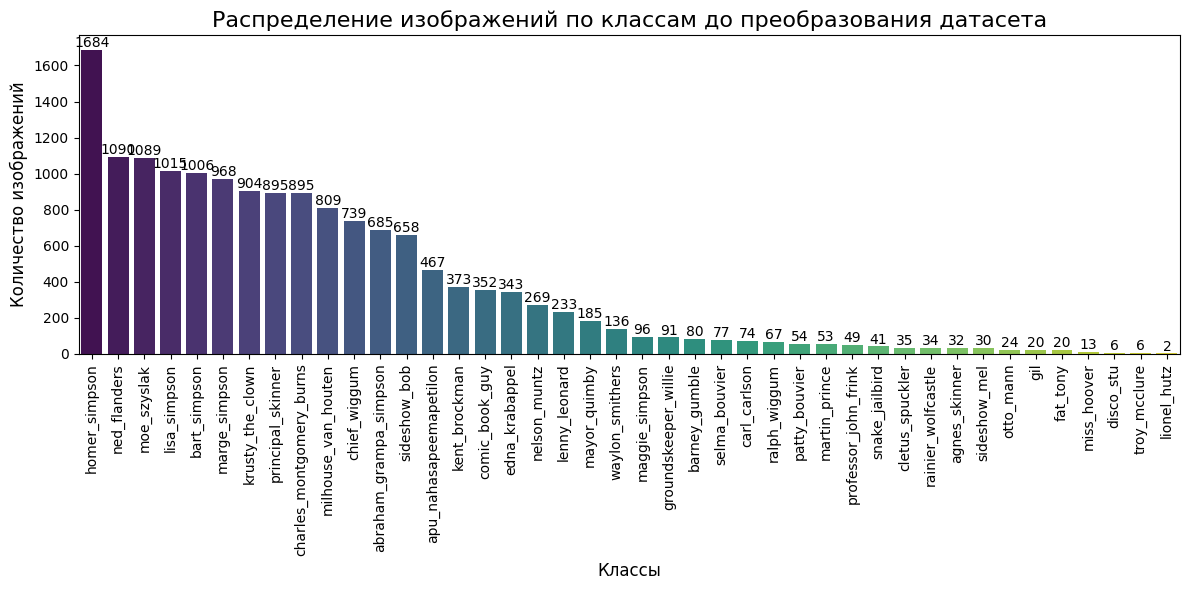

In [27]:
import seaborn as sns
import pandas as pd

# Создаем фигуру
plt.figure(figsize=(12, 6))

# Гистограмма с seaborn
plot = sns.barplot(x='class', y='counts', data=df, palette='viridis')

# Настройки отображения
plt.title('Распределение изображений по классам до преобразования датасета', fontsize=16)
plot.set_xticklabels(plot.get_xticklabels(), rotation=90)
plt.xlabel('Классы', fontsize=12)
plt.ylabel('Количество изображений', fontsize=12)

# Добавляем значения на столбцы
for p in plot.patches:
    plot.annotate(f'{int(p.get_height())}', 
                  (p.get_x() + p.get_width() / 2., p.get_height()),
                  ha='center', va='center',
                  xytext=(0, 5),
                  textcoords='offset points')

plt.tight_layout()
plt.show()

*Класс **BalancedSimpsonsDataset**, с аугментацией для картинок с заданной вероятностью и ограничением на количество картинок на класс (убрала видимый выброс для homer_simpson)*

In [28]:
np.random.seed(42)
from collections import defaultdict
import random
import numpy as np
from torchvision import transforms
from PIL import Image
from sklearn.preprocessing import LabelEncoder
import pickle
from collections import Counter

class BalancedSimpsonsDataset(Dataset):
    def __init__(self, files, mode, target_samples_per_class=None, 
                 augmentation_prob=1.0, max_samples_per_class=500):
        super().__init__()
        self.mode = mode
        self.augmentation_prob = augmentation_prob  # Вероятность аугментации
        self.max_samples_per_class = max_samples_per_class  # Максимум samples на класс
        
        if self.mode not in ['train', 'val', 'test']:
            raise ValueError(f"Invalid mode: {mode}. Use 'train', 'val' or 'test'")

        # Для тестового режима используем все файлы как есть
        if self.mode == 'test':
            self.files = sorted(files)  # Сохраняем оригинальный порядок
            self.len_ = len(self.files)
        else:
            # Группируем файлы по классам только для train/val
            self.class_files = defaultdict(list)
            for f in files:
                class_name = f.parent.name
                self.class_files[class_name].append(f)
            
            # Применяем undersampling только для train/val
            self.files = self._apply_undersampling()
            self.len_ = len(self.files)
            
            # Инициализируем LabelEncoder (только для train/val)
            self.label_encoder = LabelEncoder()
            self.labels = [path.parent.name for path in self.files]
            self.label_encoder.fit(self.labels)
            with open('label_encoder.pkl', 'wb') as le_dump_file:
                pickle.dump(self.label_encoder, le_dump_file)
        
        # Базовые трансформации (применяются всегда)
        self.base_transform = transforms.Compose([
            transforms.Resize((RESCALE_SIZE, RESCALE_SIZE)),
            transforms.ToTensor(),
            transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
        ])
        
        # Трансформации для аугментации (только для train)
        self.augmentation_transform = transforms.Compose([
            transforms.RandomResizedCrop(RESCALE_SIZE, scale=(0.8, 1.0)),
            transforms.RandomHorizontalFlip(p=0.5),
            transforms.RandomRotation(15),
            transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2),
            transforms.RandomAffine(degrees=0, translate=(0.1, 0.1)),
            transforms.ToTensor(),
            transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
        ])

    def _apply_undersampling(self):
        """Применяет undersampling, ограничивая количество примеров для каждого класса (только для train/val)"""
        undersampled_files = []
        
        for class_name, files in self.class_files.items():
            # Если класс слишком большой - берем случайное подмножество
            if len(files) > self.max_samples_per_class:
                selected_files = random.sample(files, self.max_samples_per_class)
            else:
                selected_files = files
                
            undersampled_files.extend(selected_files)
            
        return undersampled_files

    def __len__(self):
        return self.len_

    def load_sample(self, file):
        image = Image.open(file)
        image.load()
        return image

    def __getitem__(self, index):
        file = self.files[index]
        x = self.load_sample(file)
        
        # Для тестового режима - только базовые трансформации
        if self.mode == 'test':
            x = self.base_transform(x)
        # Для тренировочного режима - аугментация с вероятностью
        elif self.mode == 'train' and random.random() < self.augmentation_prob:
            x = self.augmentation_transform(x)
        else:  # val режим или случай без аугментации
            x = self.base_transform(x)
        
        if self.mode == 'test':
            return x
        else:
            label = file.parent.name
            label_id = self.label_encoder.transform([label])
            y = label_id.item()
            return x, y

    def get_class_distribution(self):
        """Возвращает распределение классов (только для train/val)"""
        if self.mode == 'test':
            return None
        return Counter([path.parent.name for path in self.files])

In [29]:
train_dataset2 = BalancedSimpsonsDataset(
    train_files, mode='train',
    max_samples_per_class=1200,
    augmentation_prob=0.8
)

df = pd.DataFrame({'class': train_dataset2.labels})
df = df['class'].value_counts().reset_index()
df.columns = ['class', 'counts']  
print(df)

                       class  counts
0              homer_simpson    1200
1               ned_flanders    1090
2                moe_szyslak    1089
3               lisa_simpson    1015
4               bart_simpson    1006
5              marge_simpson     968
6           krusty_the_clown     904
7   charles_montgomery_burns     895
8          principal_skinner     895
9        milhouse_van_houten     809
10              chief_wiggum     739
11    abraham_grampa_simpson     685
12              sideshow_bob     658
13    apu_nahasapeemapetilon     467
14             kent_brockman     373
15            comic_book_guy     352
16            edna_krabappel     343
17              nelson_muntz     269
18             lenny_leonard     233
19              mayor_quimby     185
20           waylon_smithers     136
21            maggie_simpson      96
22      groundskeeper_willie      91
23             barney_gumble      80
24             selma_bouvier      77
25              carl_carlson      74
2

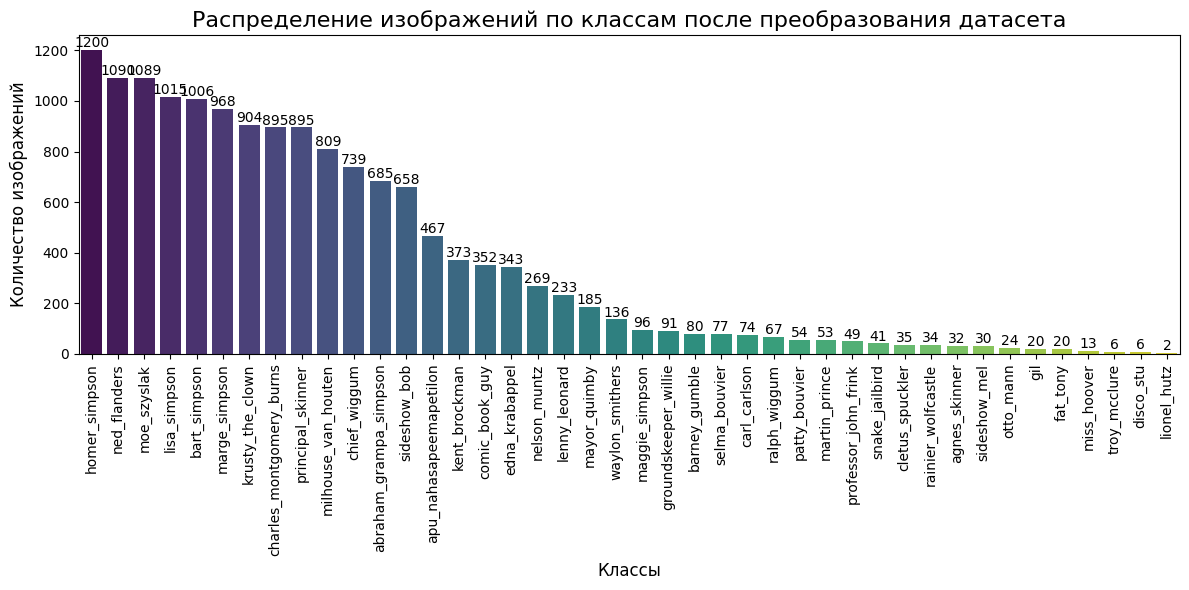

In [30]:
# Создаем фигуру
plt.figure(figsize=(12, 6))

# Гистограмма с seaborn
plot = sns.barplot(x='class', y='counts', data=df, palette='viridis')

# Настройки отображения
plt.title('Распределение изображений по классам после преобразования датасета', fontsize=16)
plot.set_xticklabels(plot.get_xticklabels(), rotation=90)
plt.xlabel('Классы', fontsize=12)
plt.ylabel('Количество изображений', fontsize=12)

# Добавляем значения на столбцы
for p in plot.patches:
    plot.annotate(f'{int(p.get_height())}', 
                  (p.get_x() + p.get_width() / 2., p.get_height()),
                  ha='center', va='center',
                  xytext=(0, 5),
                  textcoords='offset points')

plt.tight_layout()
plt.show()

# **2. Работа с архитектурой сети - ResNet**

In [31]:
import torch
import torch.nn as nn
from torchvision import models
from torch.utils.data import DataLoader, WeightedRandomSampler
from tqdm import tqdm
import torch.optim as optim

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

class ResNetSimpsons(nn.Module):
    def __init__(self, n_classes=42, pretrained=True):
        super().__init__()
        # Загружаем предобученную ResNet (можно выбрать любую версию, например resnet34, resnet50)
        self.model = models.resnet50(weights=pretrained)
        
        # Замораживаем все слои кроме последнего блока и полносвязного слоя
        for param in self.model.parameters():
            param.requires_grad = False
            
        # Размораживаем последний блок Residual для тонкой настройки
        for param in self.model.layer4.parameters():
            param.requires_grad = True
            
        # Заменяем последний полносвязный слой
        num_ftrs = self.model.fc.in_features
        self.model.fc = nn.Sequential(
            nn.Dropout(0.5),
            nn.Linear(num_ftrs, 1024),
            nn.BatchNorm1d(1024),
            nn.ReLU(inplace=True),
            nn.Dropout(0.3),
            nn.Linear(1024, n_classes)
        )
        
    def forward(self, x):
        return self.model(x)

def fit_epoch(model, train_loader, criterion, optimizer):
    model.train()
    running_loss = 0.0
    running_corrects = 0
    processed_data = 0
    
    for inputs, labels in train_loader:
        inputs = inputs.to(device)
        labels = labels.to(device)
        
        optimizer.zero_grad()
        
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        
        preds = torch.argmax(outputs, 1)
        running_loss += loss.item() * inputs.size(0)
        running_corrects += torch.sum(preds == labels.data)
        processed_data += inputs.size(0)
        
    train_loss = running_loss / processed_data
    train_acc = running_corrects.cpu().numpy() / processed_data
    return train_loss, train_acc

def eval_epoch(model, val_loader, criterion):
    model.eval()
    running_loss = 0.0
    running_corrects = 0
    processed_size = 0
    
    with torch.no_grad():
        for inputs, labels in val_loader:
            inputs = inputs.to(device)
            labels = labels.to(device)
            
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            
            preds = torch.argmax(outputs, 1)
            running_loss += loss.item() * inputs.size(0)
            running_corrects += torch.sum(preds == labels.data)
            processed_size += inputs.size(0)
    
    val_loss = running_loss / processed_size
    val_acc = running_corrects.cpu().numpy() / processed_size
    return val_loss, val_acc

def train(train_dataset, val_dataset, model, epochs=15, batch_size=32):
    model = model.to(device)
    
    train_loader = DataLoader(
        train_dataset, 
        batch_size=batch_size, 
        shuffle=True,
        pin_memory=True,
        num_workers=4
    )
    
    val_loader = DataLoader(
        val_dataset, 
        batch_size=batch_size, 
        shuffle=False,
        pin_memory=True,
        num_workers=4
    )

    history = []
    log_template = "\nEpoch {ep:03d} train_loss: {t_loss:0.4f} \
    val_loss {v_loss:0.4f} train_acc {t_acc:0.4f} val_acc {v_acc:0.4f}"

    # Используем разные learning rates для разных частей сети
    optimizer = optim.Adam([
        {'params': model.model.layer4.parameters(), 'lr': 1e-4},
        {'params': model.model.fc.parameters(), 'lr': 3e-4}
    ], weight_decay=1e-5)
    
    # Используем scheduler для уменьшения learning rate
    scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=5, gamma=0.1) #Каждые 5 эпох (step_size=5) scheduler умножает текущий LR на 0.1
    criterion = nn.CrossEntropyLoss()

    with tqdm(desc="epoch", total=epochs) as pbar_outer:
        for epoch in range(epochs):
            train_loss, train_acc = fit_epoch(model, train_loader, criterion, optimizer)
            val_loss, val_acc = eval_epoch(model, val_loader, criterion)
            
            scheduler.step()
            
            history.append((train_loss, train_acc, val_loss, val_acc))
            pbar_outer.update(1)
            tqdm.write(log_template.format(
                ep=epoch+1, 
                t_loss=train_loss,
                v_loss=val_loss, 
                t_acc=train_acc, 
                v_acc=val_acc
            ))

    return history

In [ ]:
# Инициализация модели
model_resnet = ResNetSimpsons(n_classes=42)

# Создание датасетов (используем ранее определенный BalancedSimpsonsDataset)
train_dataset = BalancedSimpsonsDataset(train_files, mode='train')
val_dataset = BalancedSimpsonsDataset(val_files, mode='val')

# Обучение модели
history = train(train_dataset, val_dataset, model_resnet, epochs=15, batch_size=32)

# Сохранение модели
torch.save(model_resnet.state_dict(), 'resnet_simpsons.pth')

In [ ]:
from sklearn.preprocessing import LabelEncoder

test_dataset = BalancedSimpsonsDataset(test_files, mode="test")
test_loader = DataLoader(test_dataset, shuffle=False, batch_size=64)
probs = predict(model_resnet, test_loader)

label_encoder = pickle.load(open("label_encoder.pkl", 'rb'))

preds = label_encoder.inverse_transform(np.argmax(probs, axis=1))
test_filenames = [path.name for path in test_dataset.files]

my_submit = pd.DataFrame({'Id': test_filenames, 'Expected': preds})
my_submit.head()

my_submit.to_csv('cnn_baseline_resnet.csv', index=False)

from IPython.display import FileLink
FileLink('cnn_baseline_resnet.csv')  

# *Final score: 0.9713*

# Изменим batch size

In [38]:
BATCH_SIZE=128

In [ ]:
# Инициализация модели
model_resnet_new_batchsize = ResNetSimpsons(n_classes=42)

# Создание датасетов (используем ранее определенный BalancedSimpsonsDataset)
train_dataset = BalancedSimpsonsDataset(train_files, mode='train')
val_dataset = BalancedSimpsonsDataset(val_files, mode='val')

# Обучение модели
history_resnet_new_batchsize = train(train_dataset, val_dataset,model_resnet_new_batchsize, epochs=15, batch_size=BATCH_SIZE)

In [ ]:
loss, acc, val_loss, val_acc = zip(*history_resnet_new_batchsize)

plt.figure(figsize=(15, 9))
plt.plot(loss, label="train_loss")
plt.plot(val_loss, label="val_loss")
plt.legend(loc='best')
plt.xlabel("epochs")
plt.ylabel("loss")
plt.show()

# Попробуем ещё изменить настройки обучения

In [ ]:
import torch
import torch.nn as nn
from torchvision import models
import torch.nn.functional as F

class ResNetSimpsons_modified(nn.Module):
    def __init__(self, n_classes=42, pretrained=True, unfreeze_layers=4):
        super().__init__()
        # Загружаем предобученную ResNet50
        self.model = models.resnet50(weights=pretrained)
        
        # Стратегия разморозки слоев
        self._unfreeze_layers(unfreeze_layers)
            
        # Улучшенный классификатор
        num_ftrs = self.model.fc.in_features
        self.model.fc = nn.Identity()  # Удаляем оригинальный fc слой
        
        self.classifier = nn.Sequential(
            nn.Linear(num_ftrs, 2048),
            nn.BatchNorm1d(2048),
            nn.LeakyReLU(0.1),
            nn.Dropout(0.5),
            
            nn.Linear(2048, 1024),
            nn.BatchNorm1d(1024),
            nn.LeakyReLU(0.1),
            nn.Dropout(0.3),
            
            nn.Linear(1024, 512),
            nn.BatchNorm1d(512),
            nn.LeakyReLU(0.1),
            
            nn.Linear(512, n_classes)
        )
        
        # Инициализация весов нового классификатора
        self._init_weights()
        
    def _unfreeze_layers(self, num_layers):
        """Размораживаем последние num_layers слоев"""
        if num_layers == 0:
            return
            
        # Всего слоев в ResNet50: 1 conv1 + 4 layerX (1-4)
        total_layers = 5
        layers_to_unfreeze = min(num_layers, total_layers)
        
        # Замораживаем все слои сначала
        for param in self.model.parameters():
            param.requires_grad = False
            
        # Постепенно размораживаем слои снизу вверх
        if layers_to_unfreeze >= 1:
            for param in self.model.layer4.parameters():
                param.requires_grad = True
                
        if layers_to_unfreeze >= 2:
            for param in self.model.layer3.parameters():
                param.requires_grad = True
                
        if layers_to_unfreeze >= 3:
            for param in self.model.layer2.parameters():
                param.requires_grad = True
                
        if layers_to_unfreeze >= 4:
            for param in self.model.layer1.parameters():
                param.requires_grad = True
                
        if layers_to_unfreeze >= 5:
            for param in self.model.conv1.parameters():
                param.requires_grad = True
    
    def _init_weights(self):
        """Инициализация весов классификатора"""
        for m in self.classifier:
            if isinstance(m, nn.Linear):
                nn.init.kaiming_normal_(m.weight, mode='fan_out', nonlinearity='leaky_relu')
                if m.bias is not None:
                    nn.init.constant_(m.bias, 0)
            elif isinstance(m, nn.BatchNorm1d):
                nn.init.constant_(m.weight, 1)
                nn.init.constant_(m.bias, 0)
    
    def forward(self, x):
        features = self.model(x)
        return self.classifier(features)
    
    def get_optimizer(self, lr=1e-3, weight_decay=1e-4):
        """Создает оптимизатор с разными learning rates для разных частей сети"""
        params = [
            {'params': [p for p in self.model.parameters() if p.requires_grad], 'lr': lr/10},
            {'params': self.model.parameters(), 'lr': lr}
        ]
        return torch.optim.AdamW(params, weight_decay=weight_decay)

In [ ]:
model_resnet_new = ResNetSimpsons_modified(n_classes=42)

# Создание датасетов (используем ранее определенный BalancedSimpsonsDataset)
train_dataset = BalancedSimpsonsDataset(train_files, mode='train')
val_dataset = BalancedSimpsonsDataset(val_files, mode='val')

# Обучение модели
history_modified = train(train_dataset, val_dataset, model_resnet_new, epochs=15, batch_size=64)

# Сохранение модели
torch.save(model_resnet.state_dict(), 'resnet_simpsons_new.pth')

In [ ]:
loss, acc, val_loss, val_acc = zip(*history_modified)

plt.figure(figsize=(15, 9))
plt.plot(loss, label="train_loss")
plt.plot(val_loss, label="val_loss")
plt.legend(loc='best')
plt.xlabel("epochs")
plt.ylabel("loss")
plt.show()

probs = predict(model_resnet_new, test_loader)

preds = label_encoder.inverse_transform(np.argmax(probs, axis=1))
test_filenames = [path.name for path in test_dataset.files]

my_submit = pd.DataFrame({'Id': test_filenames, 'Expected': preds})
my_submit.head()

my_submit.to_csv('cnn_baseline_resnet_new.csv', index=False)

from IPython.display import FileLink
FileLink('cnn_baseline_resnet_new.csv')  

Score: 0.9586

# ***Еще попытка с ResNet***

Берем ResNet18, заменяем последний слой под задачу классификации, замораживаем первые 6 слоёв

In [32]:
BATCH_SIZE=128

In [33]:
from sklearn.metrics import f1_score

In [35]:
def fit_epoch(model, train_loader, criterion, optimizer):
    running_loss = 0.0
    running_corrects = 0
    processed_data = 0
    all_labels = []
    all_preds = []

    for inputs, labels in train_loader:
        inputs, labels = inputs.to(DEVICE), labels.to(DEVICE)  
        optimizer.zero_grad()
        outputs = model(inputs)
        
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        
        preds = torch.argmax(outputs, 1)
        running_loss += loss.item() * inputs.size(0)
        running_corrects += torch.sum(preds == labels.data)
        processed_data += inputs.size(0)
        
        all_labels.extend(labels.cpu().numpy())
        all_preds.extend(preds.cpu().numpy())
        
    train_loss = running_loss / processed_data
    train_acc = running_corrects.cpu().numpy() / processed_data
    train_f1 = f1_score(all_labels, all_preds, average="weighted")
    
    return train_loss, train_acc, train_f1

def eval_epoch(model, val_loader, criterion):
    running_loss = 0.0
    running_corrects = 0
    processed_size = 0
    all_labels = []
    all_preds = []

    for inputs, labels in val_loader:
        inputs, labels = inputs.to(DEVICE), labels.to(DEVICE)

        with torch.set_grad_enabled(False):
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            preds = torch.argmax(outputs, 1)

        running_loss += loss.item() * inputs.size(0)
        running_corrects += torch.sum(preds == labels.data)
        processed_size += inputs.size(0)
        all_labels.extend(labels.cpu().numpy())
        all_preds.extend(preds.cpu().numpy())
        
    # Расчёт метрик
    val_loss = running_loss / processed_size
    val_acc = 100 * running_corrects.double() / processed_size
    val_f1 = f1_score(all_labels, all_preds, average="weighted")  # Weighted F1-score для учета дисбаланса классов

    return val_loss, val_acc, val_f1

def train(model, train_loader, val_loader, epochs, criterion, optimizer):
    history = []
    log_template = "\nEpoch {ep:03d} train_loss: {t_loss:0.4f} \
    val_loss {v_loss:0.4f} train_acc {t_acc:0.2f}% val_acc {v_acc:0.2f}% \
    train_f1 {t_f1:0.4f} val_f1 {v_f1:0.4f}"

    with tqdm(desc="epoch", total=epochs) as pbar_outer:
        scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=4, gamma=0.1)

        for epoch in range(epochs):
            model.train()

            train_loss, train_acc, train_f1 = fit_epoch(model, train_loader, criterion, optimizer)
            print("train_loss", train_loss, "train_acc", train_acc)
            scheduler.step()

            model.eval()
            val_loss, val_acc, val_f1 = eval_epoch(model, val_loader, criterion)
            history.append((train_loss, train_acc, train_f1, val_loss, val_acc, val_f1))

            pbar_outer.update(1)
            tqdm.write(log_template.format(ep=epoch+1, t_loss=train_loss,\
                                           v_loss=val_loss, t_acc=train_acc, v_acc=val_acc, \
                                          t_f1=train_f1, v_f1=val_f1))

    return history

def predict(model, test_loader):
    with torch.no_grad():
        logits = []
        model.eval()
        for inputs in test_loader:
            inputs = inputs.to(DEVICE)
            outputs = model(inputs).cpu()
            logits.append(outputs)

    probs = nn.functional.softmax(torch.cat(logits), dim=-1).numpy()
    return probs

In [36]:
model_simple_resnet = models.resnet18(pretrained=True)

model_simple_resnet.fc = nn.Linear(in_features=model_simple_resnet.fc.in_features, out_features=42, bias=True)

layer = 0
for child in model_simple_resnet.children():
    layer += 1
    if layer < 7:
        for param in child.parameters():
            param.requires_grad = False

train_dataloader = DataLoader(train_dataset, shuffle=True, batch_size=128)
val_dataloader = DataLoader(val_dataset, shuffle=False, batch_size=128)

optimizer = torch.optim.Adam(filter(lambda p: p.requires_grad, model_simple_resnet.parameters()), lr=0.001)
criterion = nn.CrossEntropyLoss()

model_simple_resnet = model_simple_resnet.to(DEVICE)

/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/resnet18-f37072fd.pth" to /root/.cache/torch/hub/checkpoints/resnet18-f37072fd.pth
100%|██████████| 44.7M/44.7M [00:00<00:00, 168MB/s] 


In [37]:
history_simple_resnet = train(model_simple_resnet, train_dataloader, val_dataloader, 10, criterion, optimizer)

epoch:   0%|          | 0/10 [00:00<?, ?it/s]

train_loss 0.5635637825207692 train_acc 0.8643862666411873


epoch:  10%|█         | 1/10 [04:59<44:52, 299.13s/it]


Epoch 001 train_loss: 0.5636     val_loss 0.4871 train_acc 0.86% val_acc 87.62%     train_f1 0.8550 val_f1 0.8704
train_loss 0.13394060628232976 train_acc 0.9660487929167463


epoch:  20%|██        | 2/10 [07:45<29:29, 221.14s/it]


Epoch 002 train_loss: 0.1339     val_loss 0.2871 train_acc 0.97% val_acc 92.80%     train_f1 0.9644 val_f1 0.9274
train_loss 0.05859005443775067 train_acc 0.9833110389196764


epoch:  30%|███       | 3/10 [10:25<22:31, 193.05s/it]


Epoch 003 train_loss: 0.0586     val_loss 0.2072 train_acc 0.98% val_acc 95.11%     train_f1 0.9829 val_f1 0.9493
train_loss 0.030802302738801485 train_acc 0.9923562010319129


epoch:  40%|████      | 4/10 [13:02<17:53, 178.93s/it]


Epoch 004 train_loss: 0.0308     val_loss 0.2945 train_acc 0.99% val_acc 92.59%     train_f1 0.9923 val_f1 0.9237
train_loss 0.013251108541862585 train_acc 0.9969424804127651


epoch:  50%|█████     | 5/10 [15:41<14:17, 171.58s/it]


Epoch 005 train_loss: 0.0133     val_loss 0.1501 train_acc 1.00% val_acc 96.45%     train_f1 0.9969 val_f1 0.9638
train_loss 0.0033773121194911253 train_acc 0.9998726033505319


epoch:  60%|██████    | 6/10 [18:19<11:08, 167.01s/it]


Epoch 006 train_loss: 0.0034     val_loss 0.1440 train_acc 1.00% val_acc 96.75%     train_f1 0.9999 val_f1 0.9669
train_loss 0.002228171331807971 train_acc 0.9998726033505319


epoch:  70%|███████   | 7/10 [20:57<08:12, 164.12s/it]


Epoch 007 train_loss: 0.0022     val_loss 0.1452 train_acc 1.00% val_acc 96.71%     train_f1 0.9999 val_f1 0.9665
train_loss 0.0015994678905340643 train_acc 0.9998726033505319


epoch:  80%|████████  | 8/10 [23:37<05:25, 162.69s/it]


Epoch 008 train_loss: 0.0016     val_loss 0.1437 train_acc 1.00% val_acc 96.89%     train_f1 0.9999 val_f1 0.9682
train_loss 0.0012701373488347852 train_acc 0.9999363016752659


epoch:  90%|█████████ | 9/10 [26:18<02:42, 162.18s/it]


Epoch 009 train_loss: 0.0013     val_loss 0.1442 train_acc 1.00% val_acc 96.79%     train_f1 0.9999 val_f1 0.9672
train_loss 0.001248093324288681 train_acc 0.9998726033505319


epoch: 100%|██████████| 10/10 [28:57<00:00, 173.79s/it]


Epoch 010 train_loss: 0.0012     val_loss 0.1411 train_acc 1.00% val_acc 96.85%     train_f1 0.9999 val_f1 0.9678


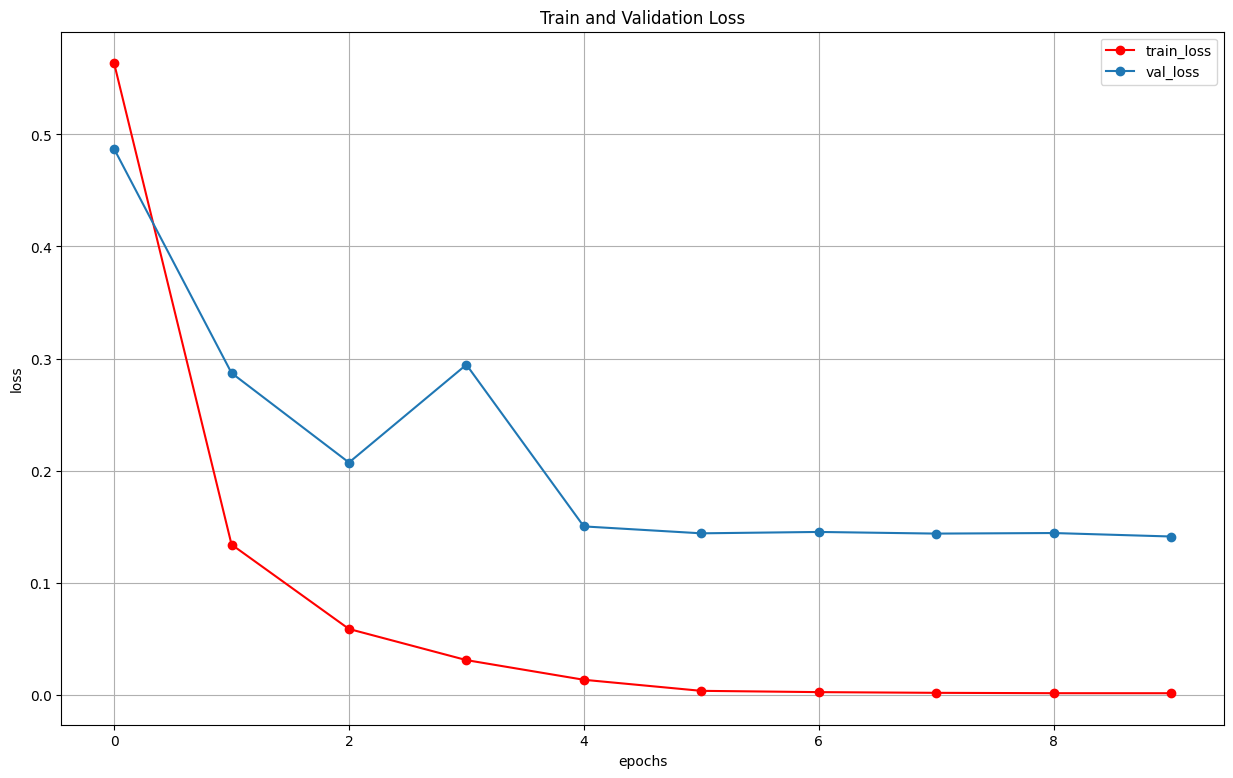

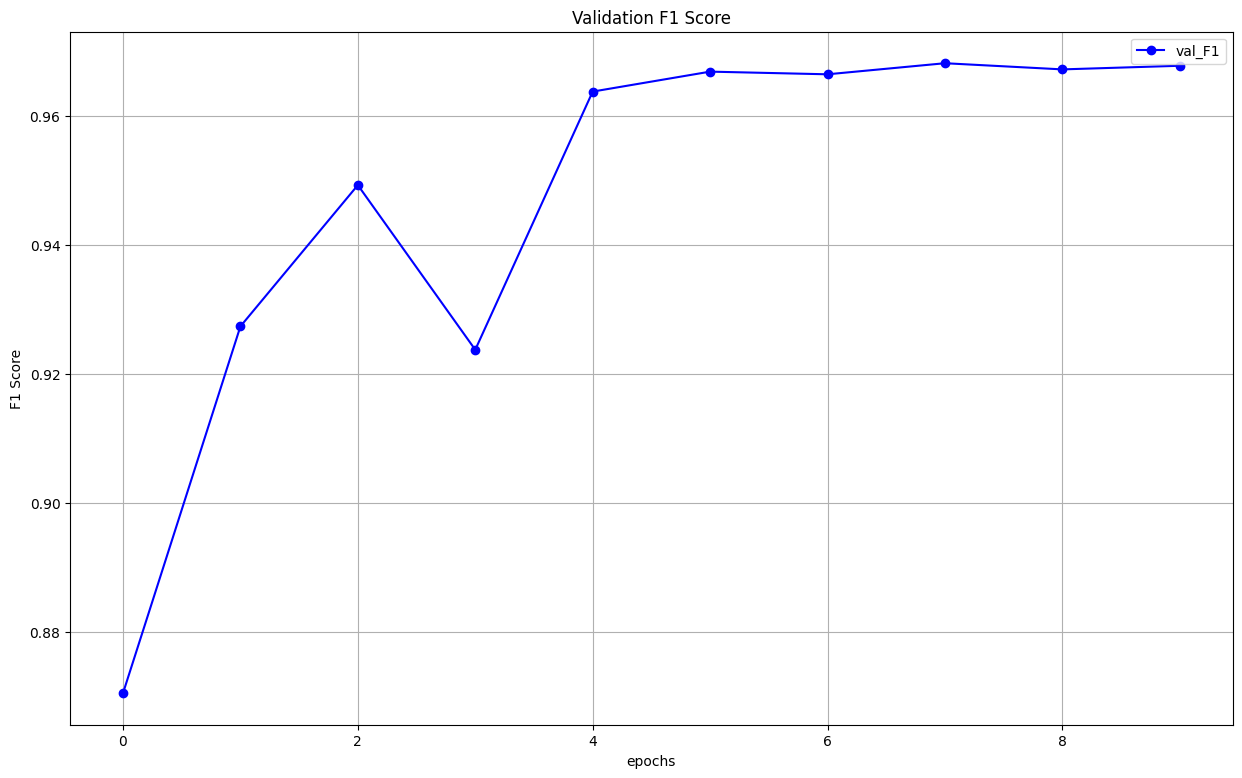

In [40]:
loss, acc, f1, val_loss, val_acc, val_f1 = zip(*history_simple_resnet)

# График для потерь на обучении и валидации
plt.figure(figsize=(15, 9))
plt.plot(loss, label="train_loss", color='r', marker='o')
plt.plot(val_loss, label="val_loss", marker='o')
plt.xlabel('epochs')
plt.ylabel('loss')
plt.legend(loc='best')
plt.title('Train and Validation Loss')
plt.grid(True)

# График для F1-score на валидации
plt.figure(figsize=(15, 9))
plt.plot(val_f1, label="val_F1", color='b', marker='o')
plt.xlabel('epochs')
plt.ylabel('F1 Score')
plt.legend(loc='best')
plt.title('Validation F1 Score')
plt.grid(True)

plt.show()

In [41]:
def predict_one_sample(model, inputs, device=DEVICE):
    """Предсказание, для одной картинки"""
    with torch.no_grad():
        inputs = inputs.to(device)
        model.eval()
        logit = model(inputs).cpu()
        probs = torch.nn.functional.softmax(logit, dim=-1).numpy()
    return probs

In [43]:
random_characters = int(np.random.uniform(0,1000))
ex_img, true_label = val_dataset[random_characters]
probs_im = predict_one_sample(model_simple_resnet, ex_img.unsqueeze(0))

idxs = list(map(int, np.random.uniform(0,1000, 20)))
imgs = [val_dataset[id][0].unsqueeze(0) for id in idxs]

probs_ims = predict(model_simple_resnet, imgs)

label_encoder = pickle.load(open("label_encoder.pkl", 'rb'))

y_pred = np.argmax(probs_ims,-1)

actual_labels = [val_dataset[id][1] for id in idxs]

preds_class = [label_encoder.classes_[i] for i in y_pred]

In [44]:
f1 = f1_score(actual_labels, y_pred, average='micro')

print("F1-оценка:", f1)

F1-оценка: 0.9


In [45]:
test_dataset = SimpsonsDataset(test_files, mode="test")
test_loader = DataLoader(test_dataset, shuffle=False, batch_size=64)
probs = predict(model_simple_resnet, test_loader)

preds = label_encoder.inverse_transform(np.argmax(probs, axis=1))
test_filenames = [path.name for path in test_dataset.files]

In [46]:
my_submit = pd.DataFrame({'Id': test_filenames, 'Expected': preds})
my_submit.to_csv('submission_resnet18.csv', index=False)
my_submit.head()

,Id,Expected
0,img0.jpg,nelson_muntz
1,img1.jpg,bart_simpson
2,img10.jpg,ned_flanders
3,img100.jpg,chief_wiggum
4,img101.jpg,apu_nahasapeemapetilon


In [47]:
from IPython.display import FileLink
FileLink('submission_resnet18.csv')  

/kaggle/working/submission_resnet18.csv

# *Score: 0.987*